<h1><h1>Pre-trained-Models with PyTorch </h1>


In this notebook, we will use pre-trained models to classify between the negative and positive samples; we will be provided with the dataset object. The particular pre-trained model will be resnet18.

<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#Part_&">Part 1</a></li>
    <li><a href="#Part_2">Part 2</a></li>
    <li><a href="#Part3">Part 3</a></li>
</ul>
<hr>


<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files in our data directory, unlike the other labs, all the data will be deleted after we close  the lab, this may take some time:


In [ ]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip

--2024-09-05 17:53:28--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  28.5MB/s    in 90s     

2024-09-05 17:54:58 (27.6 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [ ]:
!unzip -q Positive_tensors.zip

In [ ]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2024-09-05 17:57:26--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  25.8MB/s    in 79s     

2024-09-05 17:58:45 (25.4 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



We will install torchvision:


In [ ]:
!pip install torchvision

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [ ]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


In [ ]:
import os

# Vérifiez le répertoire de travail actuel
current_directory = os.getcwd()
print(f"Répertoire de travail actuel : {current_directory}")

# Vérifiez si les répertoires existent
positive_path = os.path.join(current_directory, "Positive_tensors")
negative_path = os.path.join(current_directory, "Negative_tensors")

if not os.path.exists(positive_path):
    print(f"Répertoire non trouvé : {positive_path}")
if not os.path.exists(negative_path):
    print(f"Répertoire non trouvé : {negative_path}")


Répertoire de travail actuel : /content


 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, we will skip the reshape step, conversion step to tensors and normalization step.


In [ ]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/content"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0

        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)

    # Get the length
    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):

        image=torch.load(self.all_files[idx])
        y=self.Y[idx]

        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [ ]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


<h2 id="Part_1">Part 1</h2>


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [ ]:
# Charger le modèle ResNet18 pré-entraîné
resnet18 = models.resnet18(pretrained=True)

print("ResNet18 model loaded with pre-trained weights.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]

ResNet18 model loaded with pre-trained weights.


<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [ ]:
# Définir requires_grad à False pour tous les paramètres du modèle
for param in resnet18.parameters():
    param.requires_grad = False

print("Set requires_grad to False for all parameters.")


Set requires_grad to False for all parameters.


<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs.


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [ ]:
# Remplacer la couche de sortie par une nouvelle couche pour 2 classes
resnet18.fc = nn.Linear(in_features=512, out_features=2)

print("Replaced the output layer with a new layer for 2 classes.")


Replaced the output layer with a new layer for 2 classes.


Print out the model in order to show whether you get the correct answer.<br> <b>


In [ ]:
model = resnet18
print(model)


NameError: name 'model' is not defined

<h2 id="Part_2">Part 2: Train the Model</h2>


In this part, we will train our model:


<b>Step 1</b>: Create a cross entropy criterion function


In [ ]:
# Step 1: Create the loss function

# Créer la fonction de perte d'entropie croisée
criterion = nn.CrossEntropyLoss()

print("Cross entropy loss function created.")


Cross entropy loss function created.


<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [ ]:
# Définir la taille du batch
batch_size = 100

# Créer les objets DataLoader pour l'entraînement et la validation
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

print("Training and validation DataLoader objects created.")

Training and validation DataLoader objects created.


<b>Step 3</b>: We use the following optimizer to minimize the loss


In [ ]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


**The following code calculate the accuracy on the validation data for one epoch; this took about 1h20. We made sure to calculate the accuracy on the validation data.**


In [ ]:
n_epochs = 1
loss_list = []
accuracy_list = []
correct = 0
N_test = len(validation_dataset)
N_train = len(train_dataset)
start_time = time.time()

# Pour suivre le temps de début de l'entraînement
start_time = time.time()

for epoch in range(n_epochs):
    model.train()  # Mettre le modèle en mode entraînement
    for x, y in train_loader:

        # Step 1: Clear the gradients
        optimizer.zero_grad()

        # Step 2: Make a prediction
        yhat = model(x)

        # Step 3: Calculate loss
        loss = criterion(yhat, y)

        # Step 4: Calculate gradients of parameters
        loss.backward()

        # Step 5: Update parameters
        optimizer.step()

        # Append the loss
        loss_list.append(loss.item())

    # Validation phase
    model.eval()  # Mettre le modèle en mode évaluation
    correct = 0  # Réinitialiser le compteur de corrects pour l'epoch

    for x_test, y_test in validation_loader:
        # Step 1: Make a prediction
        yhat = model(x_test)

        # Step 2: Find the max
        _, yhat_max = torch.max(yhat, 1)

        # Step 3: Calculate misclassified samples in mini-batch
        correct += (yhat_max == y_test).sum().item()

    # Calculer la précision
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy:.4f}")

end_time = time.time()
print(f"Training and validation completed in {end_time - start_time:.2f} seconds.")


<ipython-input-11-cb2b5af1a11b>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image=torch.load(self.all_files[idx])


Epoch 1, Loss: 0.04950591176748276, Accuracy: 0.9939
Training and validation completed in 4683.74 seconds.


In [ ]:
accuracy

0.9939

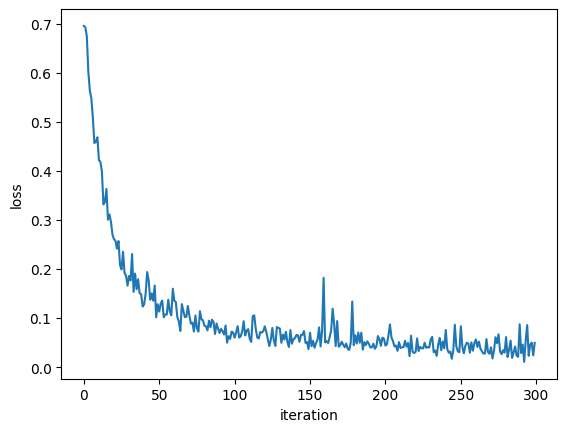

In [ ]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<h2 id="Part_3">Part 3:Find the misclassified samples</h2>


<b>Identify the first four misclassified samples using the validation data:</b>


<ipython-input-11-cb2b5af1a11b>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image=torch.load(self.all_files[idx])


Échantillon 1: Prédiction incorrecte: 1, Étiquette réelle: 0


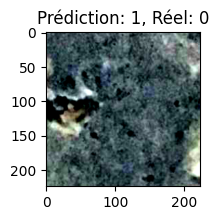

Échantillon 2: Prédiction incorrecte: 0, Étiquette réelle: 1


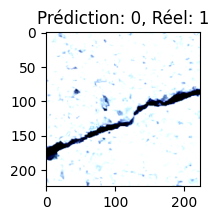

Échantillon 3: Prédiction incorrecte: 0, Étiquette réelle: 1


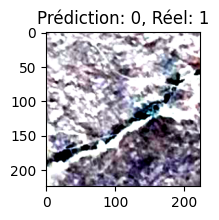

Échantillon 4: Prédiction incorrecte: 1, Étiquette réelle: 0


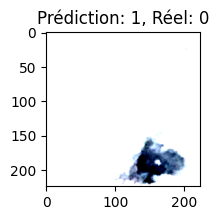

In [ ]:
# Étape pour trouver les quatre premiers échantillons mal classifiés
misclassified_samples = []  # Liste pour stocker les échantillons mal classifiés
misclassified_labels = []   # Liste pour stocker les étiquettes correspondantes
misclassified_predictions = []  # Liste pour stocker les prédictions mal classifiées

model.eval()  # Mettre le modèle en mode évaluation

# Boucle à travers les données de validation
for x_test, y_test in validation_loader:
    # Faire une prédiction
    yhat = model(x_test)

    # Trouver les indices des prédictions les plus probables
    _, yhat_max = torch.max(yhat, 1)

    # Identifier les échantillons mal classifiés
    for i in range(len(y_test)):
        if yhat_max[i] != y_test[i]:
            misclassified_samples.append(x_test[i])
            misclassified_labels.append(y_test[i].item())
            misclassified_predictions.append(yhat_max[i].item())

            # Si nous avons trouvé les quatre premiers échantillons mal classifiés, arrêter la recherche
            if len(misclassified_samples) >= 4:
                break

    # Sortir de la boucle externe si nous avons trouvé les quatre premiers échantillons mal classifiés
    if len(misclassified_samples) >= 4:
        break

# Affichage des quatre premiers échantillons mal classifiés
for idx, (sample, label, prediction) in enumerate(zip(misclassified_samples, misclassified_labels, misclassified_predictions)):
    print(f"Échantillon {idx+1}: Prédiction incorrecte: {prediction}, Étiquette réelle: {label}")

    # Afficher l'image de l'échantillon mal classifié
    plt.figure(figsize=(2, 2))
    plt.imshow(sample.permute(1, 2, 0).cpu().numpy())  # Convertir l'image du format Tensor à NumPy et permuter les dimensions
    plt.title(f"Prédiction: {prediction}, Réel: {label}")
    plt.show()


## Continue



In this project, we will build an image classifier using the VGG16 pre-trained model, and we will evaluate it and compare its performance to the model we built in the last module using the ResNet50 pre-trained model.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>    

1. <a href="#item41">Download Data
2. <a href="#item42">Part 1</a>
3. <a href="#item43">Part 2</a>  
4. <a href="#item44">Part 3</a>  

</font>
    
</div>

<a id="item41"></a>

## Download Data

We use the <code>wget</code> command to download the data for this assignment from here: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip

We use the following cells to download the data.

In [ ]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip

--2024-09-06 19:31:55--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261483817 (249M) [application/zip]
Saving to: ‘concrete_data_week4.zip’

concrete_data_week4 100%[===================>] 249.37M  13.6MB/s    in 20s     

2024-09-06 19:32:16 (12.7 MB/s) - ‘concrete_data_week4.zip’ saved [261483817/261483817]



In [ ]:
!unzip -q concrete_data_week4.zip

After we unzipped the data, we find that the data has already been divided into a train, validation, and test sets.

<a id="item42"></a>

## Part 1

In this part, we will design a classifier using the VGG16 pre-trained model. Just like the ResNet50 model, we will import the model <code>VGG16</code> from <code>keras.applications</code>.

We will essentially build your classifier as follows:
1. Import libraries, modules, and packages you will need. Make sure to import the *preprocess_input* function from <code>keras.applications.vgg16</code>.
2. Use a batch size of 100 images for both training and validation.
3. Construct an ImageDataGenerator for the training set and another one for the validation set. VGG16 was originally trained on 224 × 224 images, so make sure to address that when defining the ImageDataGenerator instances.
4. Create a sequential model using Keras. Add VGG16 model to it and dense layer.
5. Compile the mode using the adam optimizer and the categorical_crossentropy loss function.
6. Fit the model on the augmented data using the ImageDataGenerators.

We use the following cells to create your classifier.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
batch_size = 100  # Taille des lots pour l'entraînement et la validation

In [ ]:
import os

# Vérifier l'existence des répertoires
train_dir = 'concrete_data_week4/train'
val_dir = 'concrete_data_week4/val'

print("Répertoire d'entraînement trouvé :", os.path.exists(train_dir))
print("Répertoire de validation trouvé :", os.path.exists(val_dir))


Répertoire d'entraînement trouvé : True
Répertoire de validation trouvé : False


In [ ]:
# Lister le contenu du dossier concrete_data_week4
print(os.listdir('concrete_data_week4'))


['.DS_Store', 'train', 'valid', 'test']


In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Chargement des données d'entraînement
train_generator = train_datagen.flow_from_directory(
    'concrete_data_week4/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Chargement des données de validation
val_generator = val_datagen.flow_from_directory(
    'concrete_data_week4/valid',  # Chemin correct pour le répertoire de validation
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 30001 images belonging to 2 classes.
Found 9501 images belonging to 2 classes.


In [ ]:
# Charger le modèle pré-entraîné VGG16 sans les couches de classification finales
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Créer un modèle séquentiel
model = Sequential()

# Ajouter le modèle VGG16 comme base
model.add(vgg16_base)

# Aplatir les caractéristiques extraites
model.add(Flatten())

# Ajouter une couche dense pour la classification
model.add(Dense(2, activation='softmax'))  # 2 classes pour classification binaire

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=3
)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 51/300 ━━━━━━━━━━━━━━━━━━━━ 14:29:24 209s/step - accuracy: 0.5982 - loss: 8.0890

<a id="item43"></a>

## Part 2

In this part, we will evaluate your deep learning models on a test data. For this part, we will need to do the following:

1. Load your saved model that was built using the ResNet50 model.
2. Construct an ImageDataGenerator for the test set. For this ImageDataGenerator instance, you only need to pass the directory of the test images, target size, and the **shuffle** parameter and set it to False.
3. Use the **evaluate_generator** method to evaluate your models on the test data, by passing the above ImageDataGenerator as an argument. You can learn more about **evaluate_generator** [here](https://keras.io/models/sequential/).
4. Print the performance of the classifier using the VGG16 pre-trained model.
5. Print the performance of the classifier using the ResNet pre-trained model.


We use the following cells to evaluate our models.

In [ ]:
from keras.models import loa  d_model

# Charger le modèle sauvegardé basé sur ResNet50
resnet50_model = load_model('path_to_saved_resnet50_model.h5')  # Remplacez par le chemin correct

In [ ]:
test_datagen = ImageDataGenerator()

# Générer les données de test
test_generator = test_datagen.flow_from_directory(
    'concrete_data_week4/test',  # Remplacez par le chemin correct
    target_size=(224, 224),
    batch_size=100,
    shuffle=False,
    class_mode='categorical'
)

In [ ]:
# Évaluer le modèle VGG16 sur les données de test
vgg16_evaluation = model.evaluate(test_generator, steps=test_generator.samples // 100)
print(f"Performance du modèle VGG16 - Perte : {vgg16_evaluation[0]}, Précision : {vgg16_evaluation[1]}")

In [ ]:
# Évaluer le modèle ResNet50 sur les données de test
resnet50_evaluation = resnet50_model.evaluate(test_generator, steps=test_generator.samples // 100)
print(f"Performance du modèle ResNet50 - Perte : {resnet50_evaluation[0]}, Précision : {resnet50_evaluation[1]}")

<a id="item44"></a>

## Part 3

In this model, we will predict whether the images in the test data are images of cracked concrete or not. we will do the following:

1. Use the **predict_generator** method to predict the class of the images in the test data, by passing the test data ImageDataGenerator instance defined in the previous part as an argument. You can learn more about the **predict_generator** method [here](https://keras.io/models/sequential/).
2. Report the class predictions of the first five images in the test set. You should print something list this:

<center>
    <ul style="list-style-type:none">
        <li>Positive</li>  
        <li>Negative</li>
        <li>Positive</li>
        <li>Positive</li>
        <li>Negative</li>
    </ul>
</center>

Use the following cells to make your predictions.

In [ ]:
# Faire des prédictions sur les données de test avec le modèle VGG16
vgg16_predictions = model.predict(test_generator, steps=test_generator.samples // 100)

# Prendre les 5 premières prédictions
vgg16_predicted_classes = vgg16_predictions.argmax(axis=-1)[:5]

# Afficher les prédictions pour les 5 premières images
for pred in vgg16_predicted_classes:
    if pred == 0:
        print("Negative")
    else:
        print("Positive")

In [ ]:
# Faire des prédictions sur les données de test avec le modèle ResNet50
resnet50_predictions = resnet50_model.predict(test_generator, steps=test_generator.samples // 100)

# Prendre les 5 premières prédictions
resnet50_predicted_classes = resnet50_predictions.argmax(axis=-1)[:5]

# Afficher les prédictions pour les 5 premières images
for pred in resnet50_predicted_classes:
    if pred == 0:
        print("Negative")
    else:
        print("Positive")